# Etapa 2 - Modelarea datelor
### - Logistic Regression și Decision Tree -

## 1. Ipoteze formulate

Pe baza analizei din Etapa 1, am formulat urmatoarele ipoteze:

1. **Clasificare planetara** – Se pot clasifica planetele în funcție de `koi_disposition` (CONFIRMED, CANDIDATE, FALSE POSITIVE) pe baza unor altor caracteristici: `koi_period`, `koi_prad`, `koi_insol`, `koi_steff`, `koi_srad`.

2. **Planete locuibile** – Putem construi un model care, primind caracteristicile unei planete (perioada, flux, raza etc.), poate decide daca acea planeta este un **bun candidat pentru a înlocui Pământul** (adică în zona locuibila, confirmata și cu caracteristici compatibile).

3. **Scorul koi_score** este semnificativ mai mare la planetele confirmate.

*Calitatea de CONFIRMED se refera la calitatea ca acea entitate sa existe in realitate si sa se incadreze in categoria de exoplanete




In [159]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_recall_curve

##  2. Date si preprocesare - Prima ipoteza

In aceasta etapa se pregatesc datele pentru a putea fi introduse in modele. Am ales sa creez o eticheta binara (am adaugat o coloana numita `label`,care reprezinta ce vrem sa prezicem: planetele confirmate vor avea `1`, restul `0`), pentru ca modelul sa fie unul de clasificare binara. 

Urmeaza selectia atributelor - le-am ales pe cele mai relevante pentru clasificare: am eliminat `koi_score`, pentru ca acest atribut era in stransa legatura cu `koi_disposition` (a treia ipoteza a fost demonstrata), deci modelul s-ar fi concentrat mai mult pe legatura dintre cele 2 si nu alte componente.  S-au mai eliminat si koi_sloqq si koi_teq, pe baza rezultatelor obtinute de colegii mei la etapa precedenta.

Standardizarea caracteristicilor este imporatanta pentru modelul de regresie logistica.

In final, am impartit setul de date in seturi de antrenare si testare (75% antrenare si 25% testare).

In [160]:
df = pd.read_csv("exoplanets_data_cleaned.csv")  # citire date curatate

df['label'] = df['koi_disposition'].apply(lambda x: 1 if x == 2 else 0)

features = ['koi_period', 'koi_prad', 'koi_insol', 'koi_steff', 'koi_srad']
X = df[features]
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


## 3. Regresie logistica - Prima ipoteza

### De ce am ales acest model? 
Regresia logistica reprezinta un model de clasificare binar, potrivit pentru probleme cu etichete clare (0/1), usor de interpretat, ofera insight-uri despre importanta variabilelor si relatiile dintre acestea.

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1433
           1       0.51      0.86      0.65       621

    accuracy                           0.71      2054
   macro avg       0.72      0.76      0.70      2054
weighted avg       0.79      0.71      0.72      2054



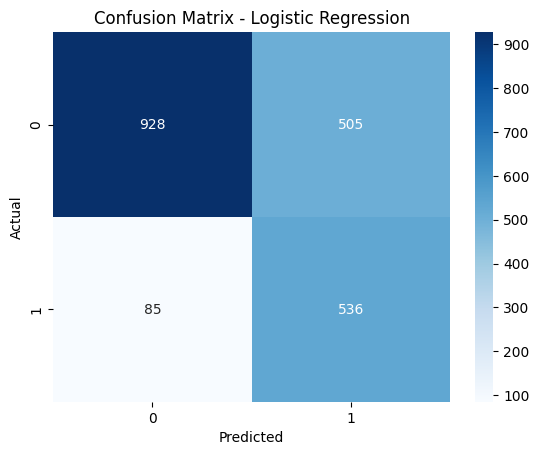

In [161]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 4. Arbori de decizie - Prima ipoteza

### De ce am ales acest model? 

Arborii de decizie sunt interpretabili vizual, genereaza reguli explicite si se potrivesc atunci cand relatiile dintre variabile nu sunt strict liniare. Sunt intuitivi.

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1433
           1       0.60      0.79      0.68       621

    accuracy                           0.78      2054
   macro avg       0.75      0.78      0.76      2054
weighted avg       0.81      0.78      0.79      2054



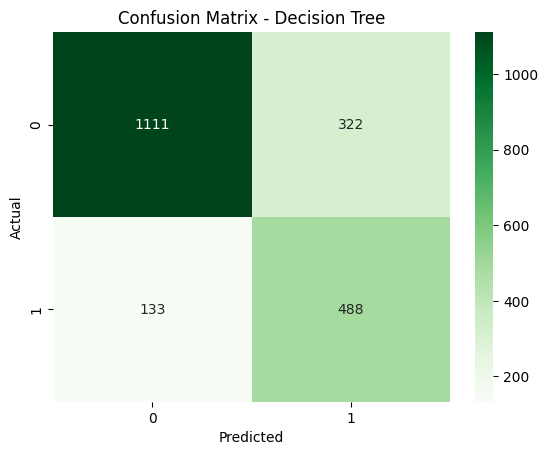

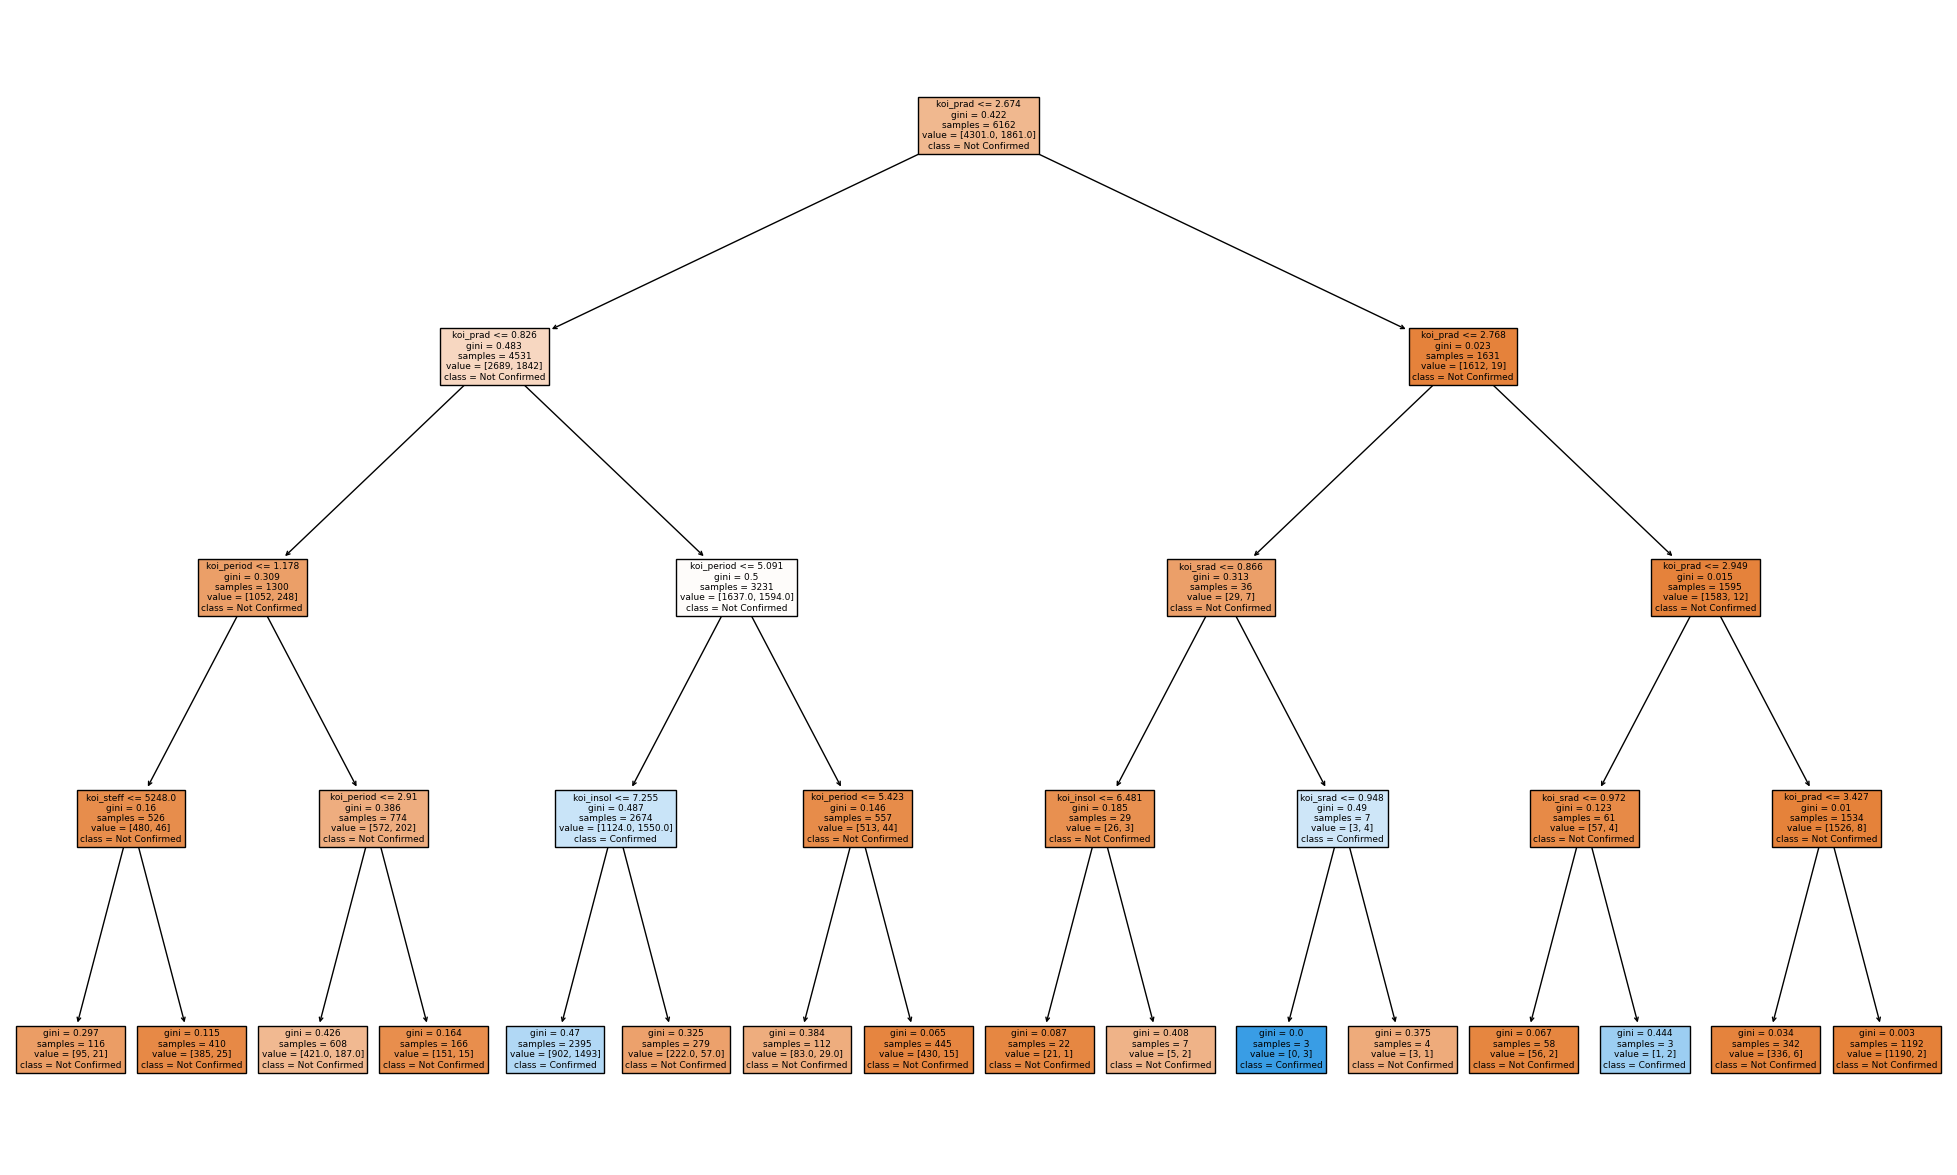

In [162]:
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(classification_report(y_test, y_pred_dt))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap="Greens")
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(25, 15))
plot_tree(dt, feature_names=features, class_names=["Not Confirmed", "Confirmed"], filled=True)
plt.show()

## Importanta atributelor

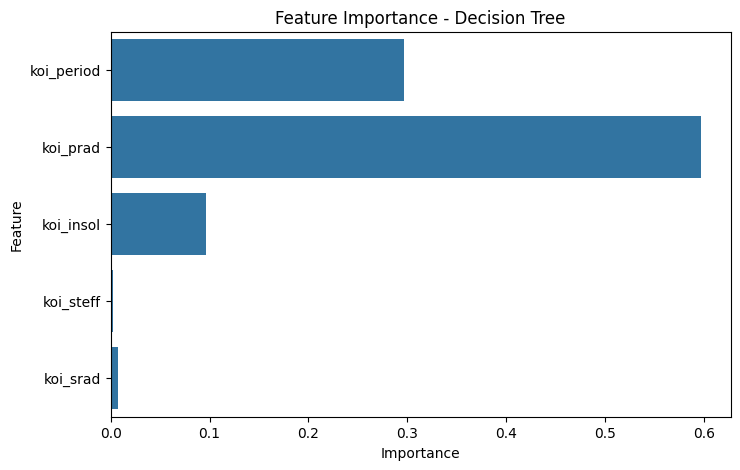

In [163]:
importances = dt.feature_importances_
feature_names = features

# Barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance - Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## **CONCLUZII** - Prima ipoteza
* Din cauza dezechilibrului dintre clase (exista mult mai multe planete neconfirmate decat confirmate), am folosit SMOTE pentru a incerca sa le echilibrez, ceea ce adus la performate usor mai ridicate, dar tot nu perfecte. Se observa ca am obtinut un numar destul de mare de false pozitive, ceea ce, pentru setul nostru de date nu este un lucru asa rau (mai bine sa trebuiasca o reverificare a planetelor clasificate ca fiind confirmate, decat sa pierdem din vedere multe exoplanete eligibile).
* Ambii algoritmi au performante decente (peste 70%), insa arborii le au putin mai ridicate, iar in cazul lor putem opta si pentru o interpretare vizuala mai buna si pentru analiza importantei atributelor.
* Pot afirma, pe baza rezultatelor obtinute, ca se confirma prima ipoteza, desi cred ca alte modele de ML ar fi putut fi mai potrivite si mai performante.


## 5. Date si preprocesare - A doua ipoteza

Modul de lucru este similar cu cel de la prima ipoteza, doar ca de data asta label-ul este format in felul urmator: 1 daca are caracteristicile unei planete locuibile (raza planetara mai mica decat 3 raze ale pamantului si fluxul de radiatie solara sa fie intre 0.75 si 1.5), 0 altfel. Vrem ca modelul sa prezica daca o planeta ar putea inlocui Pamantul sau nu.

In [164]:
df = pd.read_csv("exoplanets_data_cleaned.csv")

def is_habitable(row):
    return int(
        0.75 <= row['koi_insol'] <= 1.5 and
        row['koi_prad'] <= 3
    )

df['locuibila'] = df.apply(is_habitable, axis=1)

features = ['koi_score', 'koi_teq', 'koi_period', 'koi_steff', 'koi_slogg', 'koi_kepmag']
X = df[features]
y = df['locuibila']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)



## 6. Logistic Regression -  A doua ipoteza

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1936
           1       0.37      0.98      0.54       118

    accuracy                           0.90      2054
   macro avg       0.68      0.94      0.74      2054
weighted avg       0.96      0.90      0.92      2054



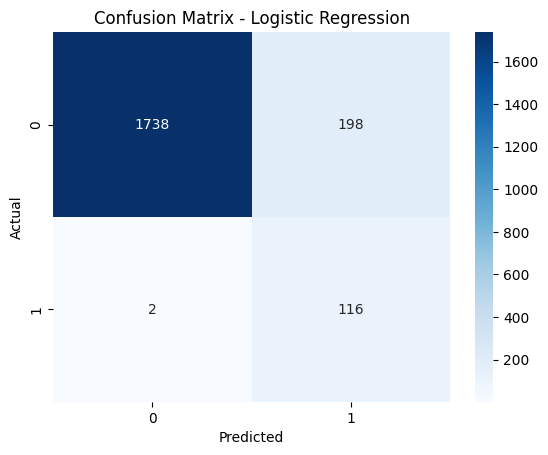

In [165]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))


sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 7. Decision Tree - A doua ipoteza

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1936
           1       0.85      1.00      0.92       118

    accuracy                           0.99      2054
   macro avg       0.92      0.99      0.96      2054
weighted avg       0.99      0.99      0.99      2054



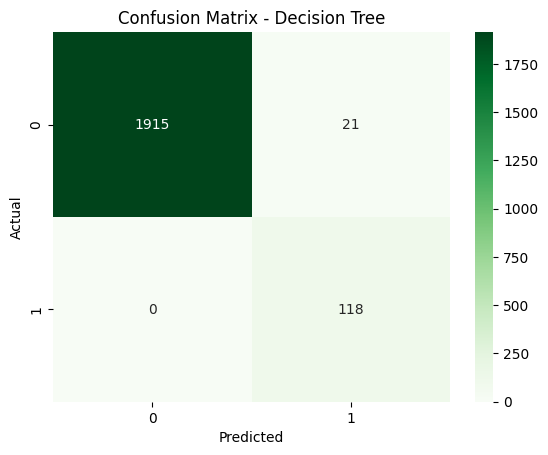

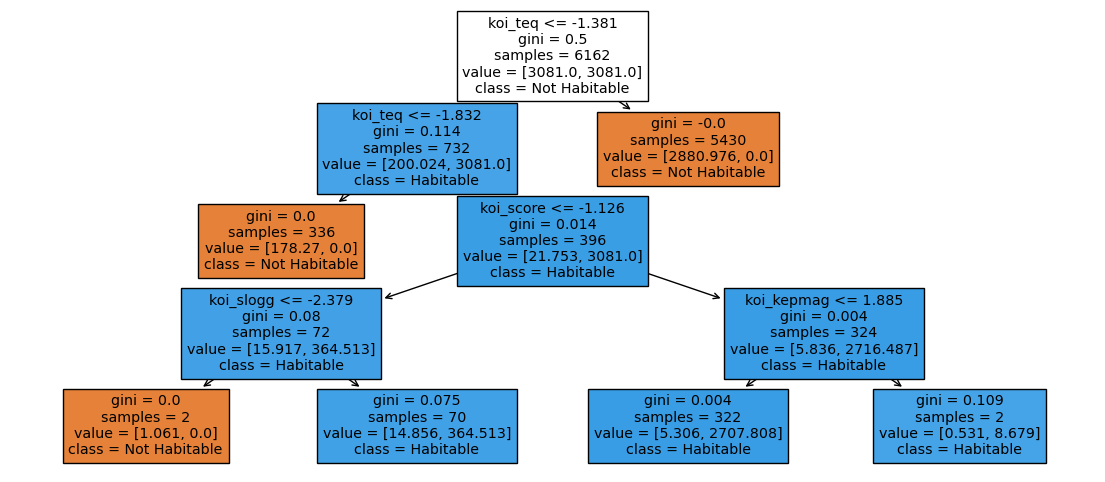

In [168]:
dt = DecisionTreeClassifier(max_depth=4, class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(classification_report(y_test, y_pred_dt))

sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap="Greens")
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(14, 6))
plot_tree(dt, feature_names=features, class_names=["Not Habitable", "Habitable"], filled=True)
plt.show()

## **CONCLUZII** - A doua ipoteza
* Scoruri mai mari decat la prima ipoteza; aceeasi idee cu falsele negative: mai bine se mai verifica o data de catre oamenii de stiinta planetele care sunt detectate ca fiind locuibile, decat sa pierdem din vedere o posibila inlocuitoare a Pamantului.
* De data aceasta, strategia pentru dezechilibrul dintre clase (care sunt mult mai dezechilibrate decat in primul caz - foarte putine planete din setul de date indeplinesc coditiile pentru a putea fi considerate posibil locuibile) a fost hiperparametrul `class_weight='balanced'`
* Pot afirma ca si aceasta ipoteza a fost confirmata